<a href="https://colab.research.google.com/github/DrAlexSanz/micrograd/blob/main/03_Makemore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal of this notebook

* Following Karpathy's 4rd lecture on Makemore

https://youtu.be/P6sfmUTpUmc?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&t=5775

In [1]:
import random
import torch
import torch.nn.functional as F # for later
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-01-10 13:12:12--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-01-10 13:12:12 (13.5 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# Same thing but in a function
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### MLP definition

In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
#b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden)) # This one replaces the bias. It's like an integration constant when you change variables. You replace it by another constant.
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12070


### So now, let's use pytorch's functions for optimizing on one batch.

In [8]:
# Now I add the backward pass and put it in the loop, to optimize only on one batch. I should overfit quickly.

max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # build a mini batch. Like this instead of full gradient descent, we have SGD. Iterations are faster but have noise.
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # select the batch

    # Forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # +b1 # Hidden layer previous to activation
    bnmean_i = hpreact.mean(0, keepdim = True)
    bnstd_i = hpreact.std(0, keepdim = True)
    hpreact = bngain * (hpreact - bnmean_i)/ bnstd_i + bnbias # Batch normalization. If I want Gaussian distributions, let's make them. This is all differentiable.

    with torch.no_grad(): # I don't need to backpropagate this, it's just an approximation, calculated as a "running average". Alternatively, do the calculation once for the whole training set at the end.
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean_i
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd_i

    h = torch.tanh(hpreact) # Hidden layer after activation
    logits = h @ W2 #+b2 # Output layer
    loss = F.cross_entropy(logits, Yb) # Loss

    # Backward pass
    for p in parameters:
        p.grad = torch.zeros(p.shape, dtype=torch.float32) # Set them to 0. Apparently python doesn't like None insetad of 0
    loss.backward() # calculate gradients

    # Gradient update stage
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad # lr is 0.1 here

    # track lr and loss
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item()) # Nicer plotting


      0/ 200000: 3.3195
  10000/ 200000: 2.4093
  20000/ 200000: 2.3101
  30000/ 200000: 1.9834
  40000/ 200000: 2.0810
  50000/ 200000: 1.8933
  60000/ 200000: 2.0694
  70000/ 200000: 2.3146
  80000/ 200000: 1.7209
  90000/ 200000: 2.0356
 100000/ 200000: 2.0370
 110000/ 200000: 2.3104
 120000/ 200000: 2.2858
 130000/ 200000: 2.3039
 140000/ 200000: 1.9800
 150000/ 200000: 2.0748
 160000/ 200000: 2.1306
 170000/ 200000: 2.2551
 180000/ 200000: 1.8987
 190000/ 200000: 2.1405


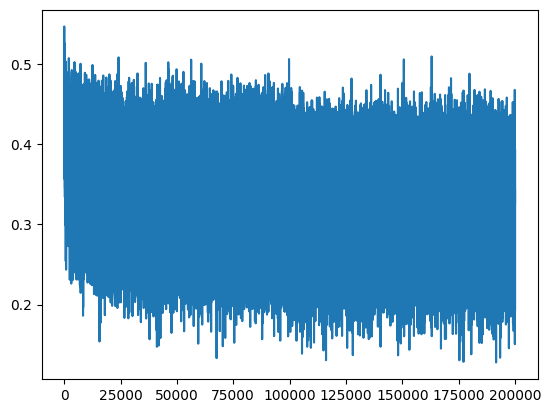

In [9]:
plt.plot(lossi)

In [11]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 #+ b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674996376037598
val 2.106266498565674


In [48]:
#pytorch-ify the code

class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
      self.weight = torch.randn((fan_in, fan_out), generator = g)/fan_in ** 0.5
      self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
      self.out = x @ self.weight
      if self.bias is not None:
          self.out += self.bias

      return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True # For the moving average, I need to know if I'm training or not

        # Parameters
        self.gamma = torch.ones(dim) # the bn gain
        self.beta = torch.zeros(dim) # the bn bias

        # Buffers (the running parameters)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            x_mean = x.mean(dim = 0, keepdim = True)
            x_var = x.var(dim = 0, keepdim = True)
        else:
            x_mean = self.running_mean
            x_var = self.running_var
        x_hat = (x - x_mean)/torch.sqrt(x_var + self.eps) # normalize to unit variance
        self.out = self.gamma * x_hat + self.beta

        # Update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
      self.out = torch.tanh(x)
      return self.out

    def parameters(self):
        return []


########################################
# Finished definitions

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# And now I build the network

C = torch.randn((vocab_size, n_embd), generator = g)

layers = [
          Linear(n_embd * block_size, n_hidden),
          BatchNorm1d(n_hidden),
          Tanh(),
          Linear(n_hidden, n_hidden),
          BatchNorm1d(n_hidden),
          Tanh(),
          Linear(n_hidden, n_hidden),
          BatchNorm1d(n_hidden),
          Tanh(),
          Linear(n_hidden, n_hidden),
          BatchNorm1d(n_hidden),
          Tanh(),
          Linear(n_hidden, n_hidden),
          BatchNorm1d(n_hidden),
          Tanh(),
          Linear(n_hidden, vocab_size)
          ]

with torch.no_grad():
    # Make the last layer less confident than the other ones
    layers[-1].weight *= 0.1
    # All other layers, apply gain
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()] # Nested fors
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47497


In [49]:
# Same optimization as last time

max_steps = 200_000
batch_size = 32
lossi = []
ud = [] # Update (grad * lr) to data ration

for i in range(max_steps):

    # build a mini batch. Like this instead of full gradient descent, we have SGD. Iterations are faster but have noise.
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # select the batch

    # Forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # Backward pass
    for layer in layers:
        layer.out.retain_grad() # After debug, remov this

    for p in parameters:
        p.grad = None

    loss.backward() # calculate gradients

    # Gradient update stage
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad # lr is 0.1 here

    # track lr and loss
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item()) # Nicer plotting
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    if i >= 10000:
        #break # Train only 10K iterations
        pass

      0/ 200000: 3.2829
  10000/ 200000: 2.3454
  20000/ 200000: 2.1184
  30000/ 200000: 1.9844
  40000/ 200000: 2.1694
  50000/ 200000: 2.2676
  60000/ 200000: 1.7792
  70000/ 200000: 2.2124
  80000/ 200000: 2.3653
  90000/ 200000: 1.9494
 100000/ 200000: 2.5004
 110000/ 200000: 2.1618
 120000/ 200000: 2.0502
 130000/ 200000: 1.9703
 140000/ 200000: 1.7234
 150000/ 200000: 1.8835
 160000/ 200000: 1.8549
 170000/ 200000: 1.9398
 180000/ 200000: 2.2365
 190000/ 200000: 2.1024


Layer 2 (      Tanh): mean +0.02, std 0.68, saturated: 14.44%
Layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 16.66%
Layer 8 (      Tanh): mean -0.03, std 0.75, saturated: 17.06%
Layer 11 (      Tanh): mean +0.00, std 0.77, saturated: 19.03%
Layer 14 (      Tanh): mean +0.01, std 0.60, saturated: 6.47%


Text(0.5, 1.0, 'Distribution of activations')

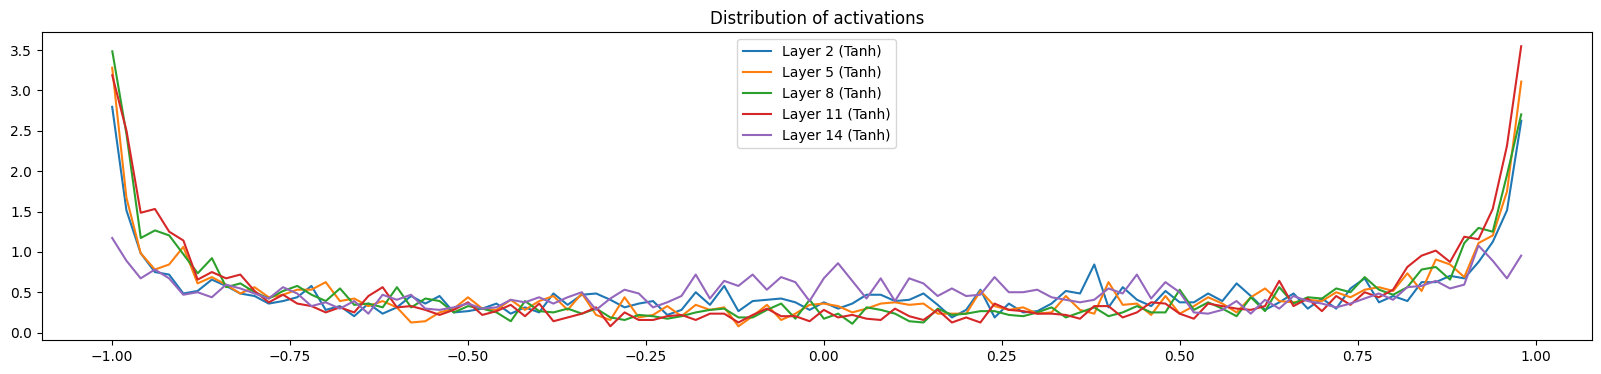

In [50]:
# Visualize histograms of activation

plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # Exclude output layer, it's a softmax
    if isinstance(layer, Tanh):
        t = layer.out
        print("Layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("Distribution of activations")

Layer 2 (      Tanh): mean -0.000000, std 3.691197e-03
Layer 5 (      Tanh): mean +0.000000, std 3.581212e-03
Layer 8 (      Tanh): mean -0.000000, std 3.656632e-03
Layer 11 (      Tanh): mean -0.000000, std 3.460976e-03
Layer 14 (      Tanh): mean +0.000070, std 6.314055e-03


Text(0.5, 1.0, 'Distribution of activations')

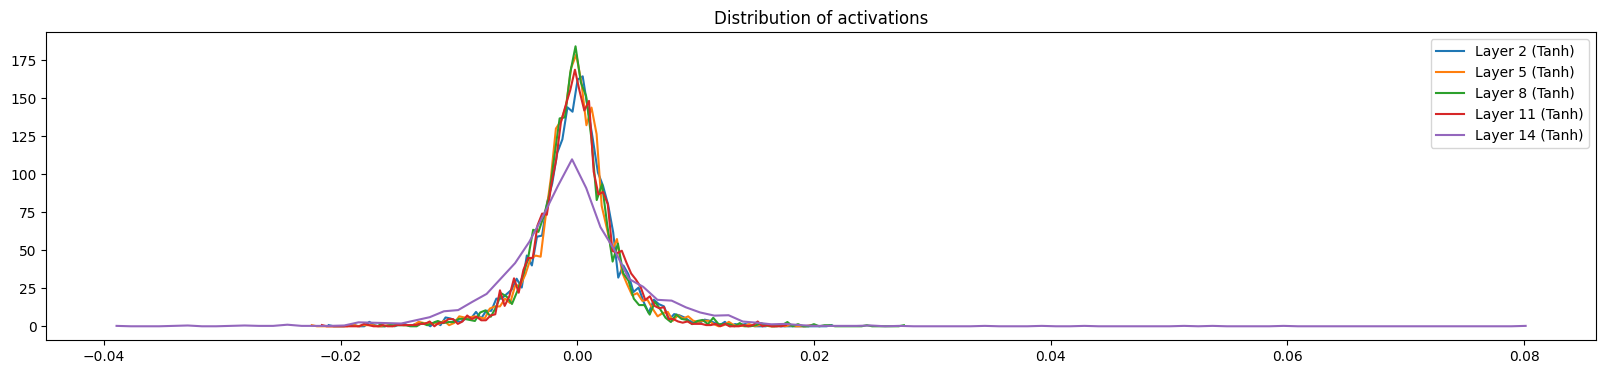

In [51]:
# Visualize histograms of gradients

plt.figure(figsize = (20, 4))
legends = []
for i, layer in enumerate(layers[:-1]): # Exclude output layer, it's a softmax
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print("Layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"Layer {i} ({layer.__class__.__name__})")
plt.legend(legends);
plt.title("Distribution of activations")

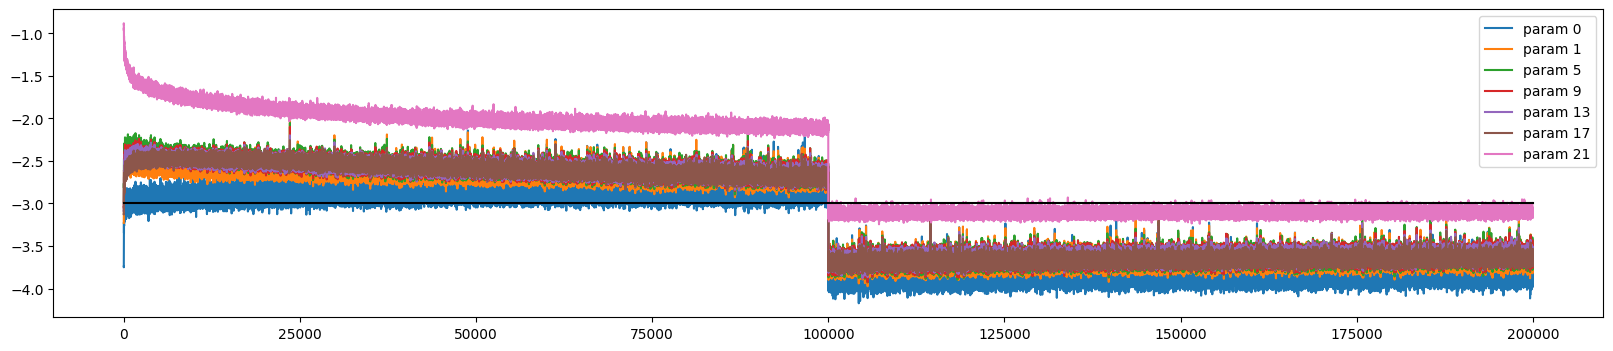

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [53]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

RuntimeError: probability tensor contains either `inf`, `nan` or element < 0